# Numerical feature engineering


## Purpose of this notebook

We want to check if we can add some transformations to numerical features based on domain knowledge to improve the performance of our models.

We will try to discretized some features and also check if certain ones are above/below a normal value for the particular feature (e.g. if bilirubin is above 1.2, it is considered high).

In [1]:
# essentials
import os
import pathlib

import pandas as pd
import numpy as np
from tqdm import tqdm

# visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MaxAbsScaler, PowerTransformer, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SequentialFeatureSelector, RFECV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone as clone_model
from sklearn.metrics import classification_report, confusion_matrix, log_loss


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

# others
import xgboost as xgb 
import lightgbm as lgb
import catboost as cb

RANDOM_SEED = 64

In [2]:
IN_KAGGLE = False
kaggle_folder = "/kaggle/input/playground-series-s3e26"
local_folder = "./data"
train_df = pd.read_csv(kaggle_folder if IN_KAGGLE else local_folder + "/train.csv", index_col="id")
test_df = pd.read_csv(kaggle_folder if IN_KAGGLE else local_folder  + "/test.csv", index_col="id")
target_column = "Status"

target_map = {"C": "censored", "CL": "censored due to liver transplant", "D": "death"} # for readability of charts
train_df[target_column] = train_df[target_column].map(target_map)

categorical_features = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]
numerical_features = ["N_Days", "Age", "Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]

We will start with baseline model taking in the raw features, transform the features and compare if there is any improvement in the same models performance.

In [3]:
def feature_engineering(df):
    
    #df['Drug'] = df['Drug'].map({"D-penicillamine": 1,"Placebo": 0})
    #df['Sex'] = df['Sex'].map({"F": 1,"M": 0})

    df["Stage"] = df["Stage"].apply(lambda x: str(x))
    return df


train_df = feature_engineering(train_df)

X = train_df.drop(columns=target_column)
y = train_df[target_column]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=RANDOM_SEED, stratify=y, shuffle=True)

le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

numeric_transformer = Pipeline(
    [
        #("power_transformer", PowerTransformer()),
        ("scaler", StandardScaler()),
        
    ]
)

categorical_transformer = Pipeline(
    [
        ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)



models = {
    "voting classifier 1": VotingClassifier(
        estimators=[
            ("xgb", xgb.XGBClassifier(
                objective="multi:softprob", random_state=RANDOM_SEED, n_jobs=-1,
                subsample=0.8,
                min_child_weight=7,
                max_depth=7,
                reg_lambda=0.9,
                gamma=0.9,
                eta=0.08,
                colsample_bytree=0.5,
                reg_alpha=0.5,
                verbosity=0
            )),
            ("catboost", cb.CatBoostClassifier(random_state=RANDOM_SEED, verbose=False)),
            ("lightgbm", lgb.LGBMClassifier(random_state=RANDOM_SEED, n_jobs=8, verbose=-1)),
        ],
        voting="soft",
        n_jobs=-1,
        verbose=1),
    "default lightgbm": lgb.LGBMClassifier(random_state=RANDOM_SEED, n_jobs=4),
    "stacking classifier 1": StackingClassifier(
        estimators=[
            ("xgb", xgb.XGBClassifier(
                objective="multi:softprob", random_state=RANDOM_SEED, n_jobs=-1,
                subsample=0.8,
                min_child_weight=7,
                max_depth=7,
                reg_lambda=0.9,
                gamma=0.9,
                eta=0.08,
                colsample_bytree=0.5,
                reg_alpha=0.5,
                verbosity=0
            )),
            ("catboost", cb.CatBoostClassifier(random_state=RANDOM_SEED, verbose=False)),
        ],
        stack_method="predict_proba",
        final_estimator=LogisticRegression(),
        n_jobs=-1,
        verbose=1),
}

data = []
for model_name, model in models.items():
    print(f"Training {model_name}")
    clf = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("classifier", model),
        ]
    )

    cc_cv = CalibratedClassifierCV(clf, cv=skf)

    cc_cv.fit(X_train, y_train)
    y_pred_proba = cc_cv.predict_proba(X_val)
    y_pred = cc_cv.predict(X_val)
    
    cr = classification_report(y_val, y_pred, output_dict=True)

    recall_class_0 = confusion_matrix(y_val, y_pred, normalize="true")[0, 0]
    recall_class_1 = confusion_matrix(y_val, y_pred, normalize="true")[1, 1]
    recall_class_2 = confusion_matrix(y_val, y_pred, normalize="true")[2, 2]
    data.append({
        "model": model_name, 
        "log_loss_score": log_loss(y_val, y_pred_proba),
        "avg_precision": cr["macro avg"]["precision"],
        "f1_score": cr["macro avg"]["f1-score"],
        "recall_class_0": recall_class_0,
        "recall_class_1": recall_class_1,
        "recall_class_2": recall_class_2,
    })    

pd.DataFrame(data).drop_duplicates().sort_values(by=["log_loss_score", "recall_class_1"], ascending=[True, False])

Training voting classifier 1
[Voting] ................. (3 of 3) Processing lightgbm, total=   0.4s
[Voting] ...................... (1 of 3) Processing xgb, total=   1.6s
[Voting] ................. (2 of 3) Processing catboost, total=   3.4s
[Voting] ................. (3 of 3) Processing lightgbm, total=   0.3s
[Voting] ...................... (1 of 3) Processing xgb, total=   1.4s
[Voting] ................. (2 of 3) Processing catboost, total=   3.3s
[Voting] ................. (3 of 3) Processing lightgbm, total=   0.3s
[Voting] ...................... (1 of 3) Processing xgb, total=   1.4s
[Voting] ................. (2 of 3) Processing catboost, total=   3.5s
Training default lightgbm
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1924
[LightGBM] [Info] Number of data points in the

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


Okay, now we can work on the data!

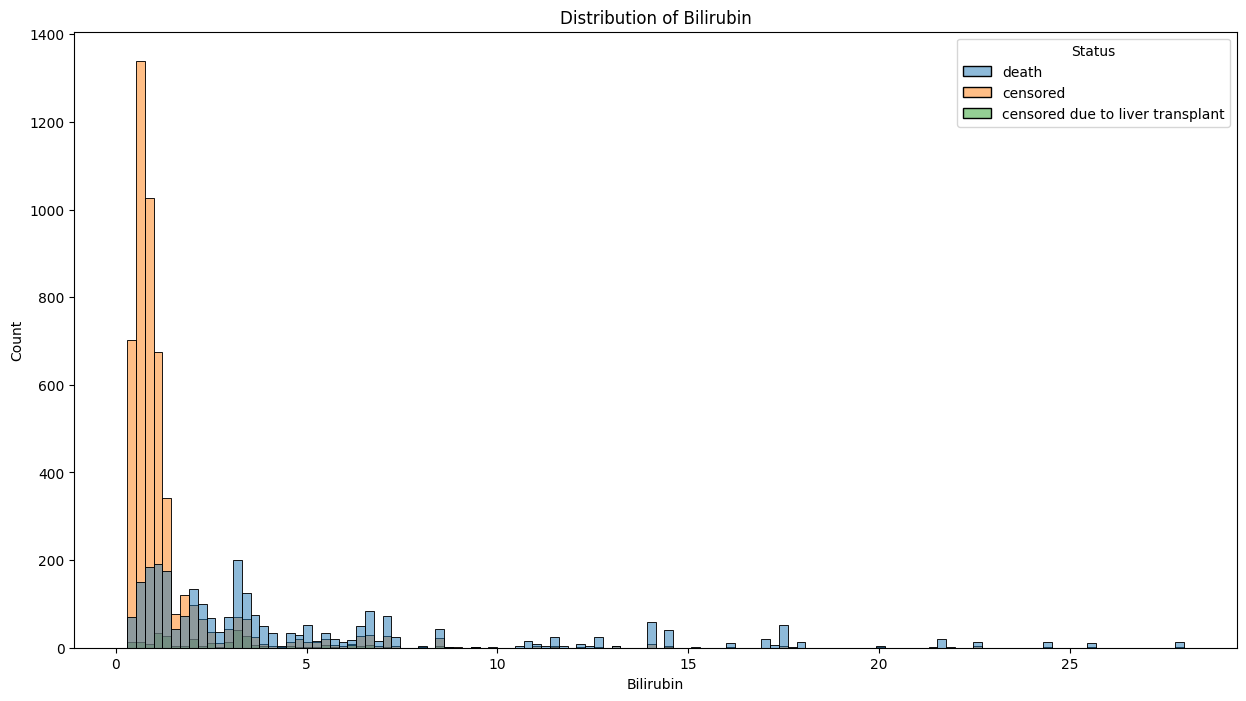

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.title.set_text(f"Distribution of Bilirubin")
sns.histplot(data=train_df, x="Bilirubin", hue=target_column, ax=ax)
plt.show()

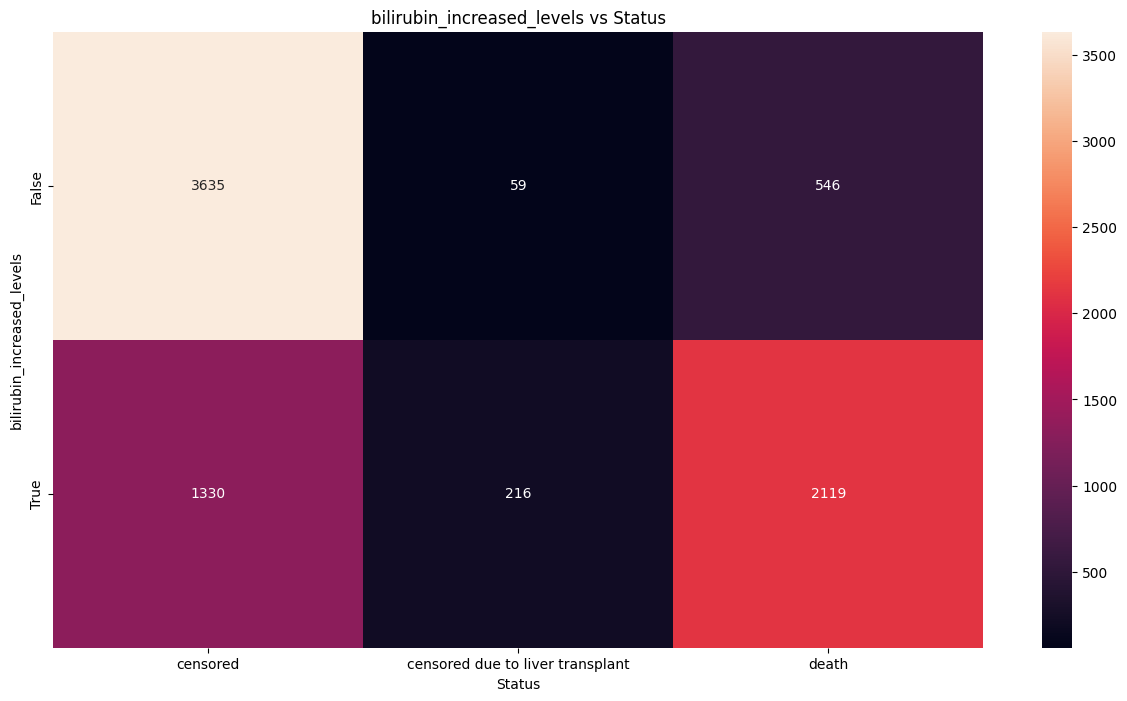

In [5]:
# NEW FEATURE: bilirubin_increased_levels
train_df['bilirubin_increased_levels'] = train_df['Bilirubin'] > 1.1
# create a heatmap of different "bilirubin_increased_levels" and "Status"
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.title.set_text(f"bilirubin_increased_levels vs Status")
sns.heatmap(pd.crosstab(train_df['bilirubin_increased_levels'], train_df[target_column]), annot=True, fmt='d', ax=ax)
plt.show()

count    7905.000000
mean      350.561923
std       195.379344
min       120.000000
25%       248.000000
50%       298.000000
75%       390.000000
max      1775.000000
Name: Cholesterol, dtype: float64


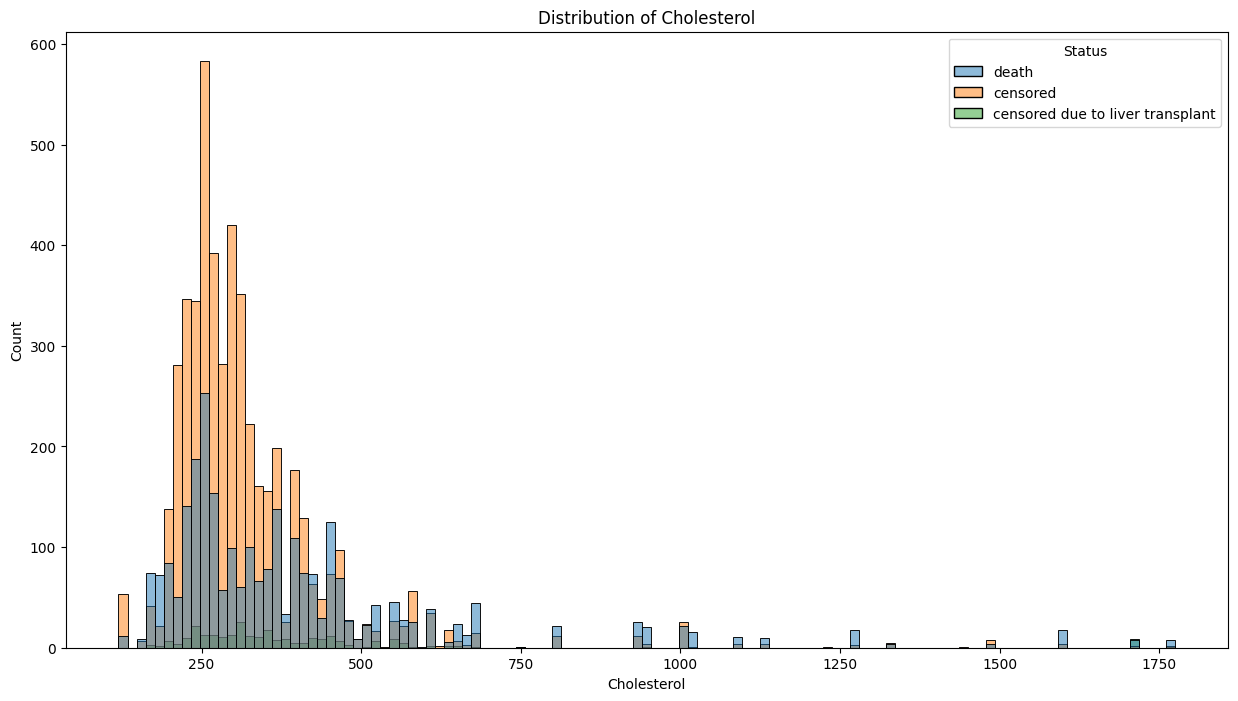

In [6]:
print(train_df['Cholesterol'].describe())
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.title.set_text(f"Distribution of Cholesterol")
sns.histplot(data=train_df, x="Cholesterol", hue=target_column, ax=ax)
plt.show()

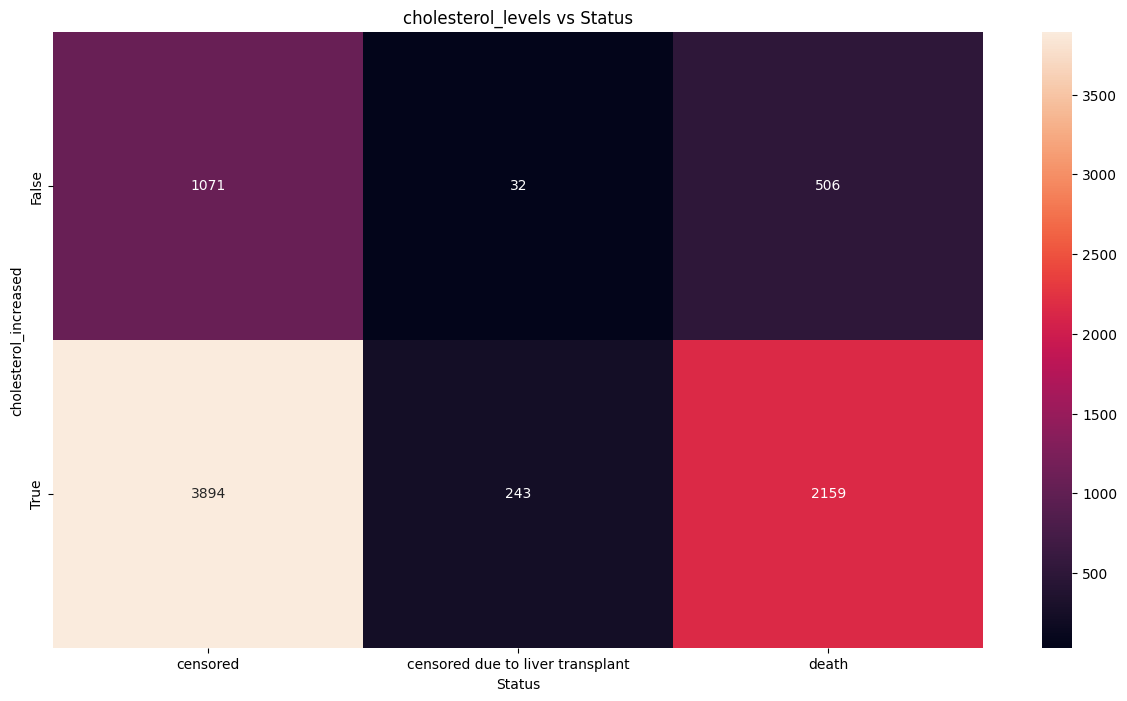

In [7]:
# NEW FEATURE: cholesterol_increased
# Desirable: Less than 200 mg/dL
# Borderline High: 200–239 mg/dL
# High: 240 mg/dL and above

train_df['cholesterol_increased'] = train_df['Cholesterol'] > 240

# create a heatmap of different "cholesterol_levels" and "Status"   
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.title.set_text(f"cholesterol_levels vs Status")
sns.heatmap(pd.crosstab(train_df['cholesterol_increased'], train_df[target_column]), annot=True, fmt='d', ax=ax)
plt.show()

count    7905.000000
mean        3.548323
std         0.346171
min         1.960000
25%         3.350000
50%         3.580000
75%         3.770000
max         4.640000
Name: Albumin, dtype: float64


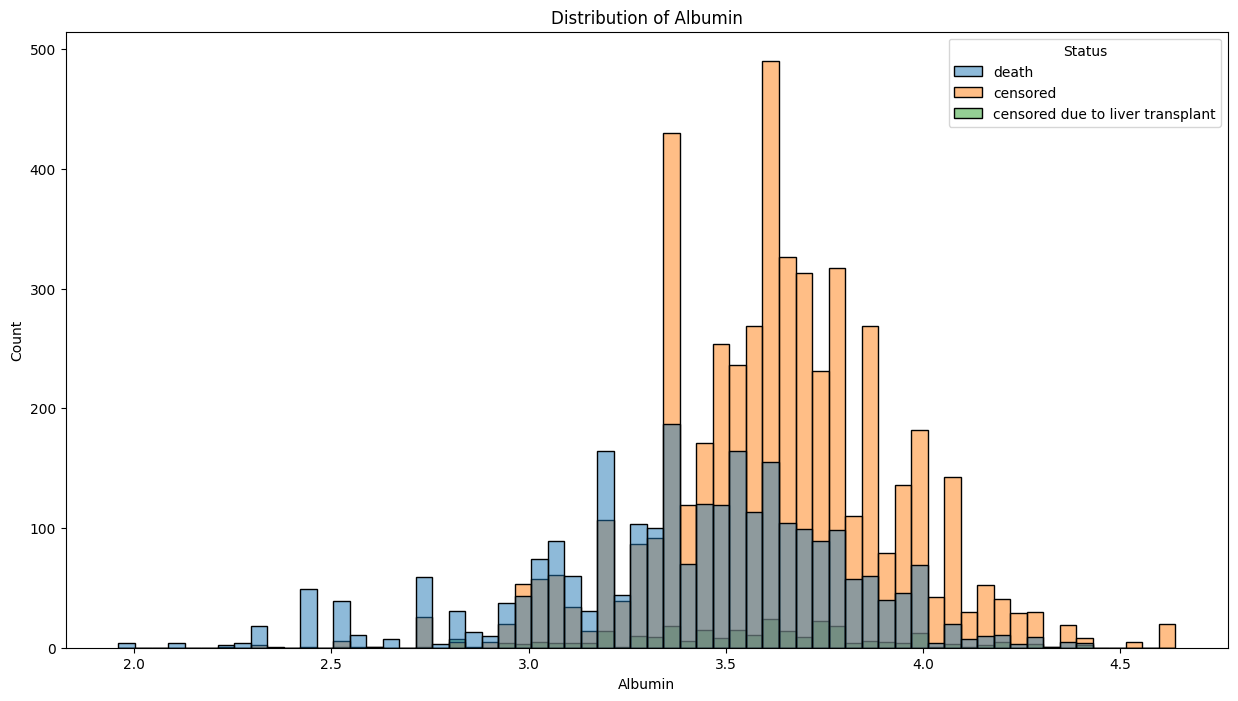

In [8]:
print(train_df['Albumin'].describe())
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.title.set_text(f"Distribution of Albumin")
sns.histplot(data=train_df, x="Albumin", hue=target_column, ax=ax)
plt.show()

<Axes: title={'center': 'albumin_low vs Status'}, xlabel='Status', ylabel='albumin_low'>

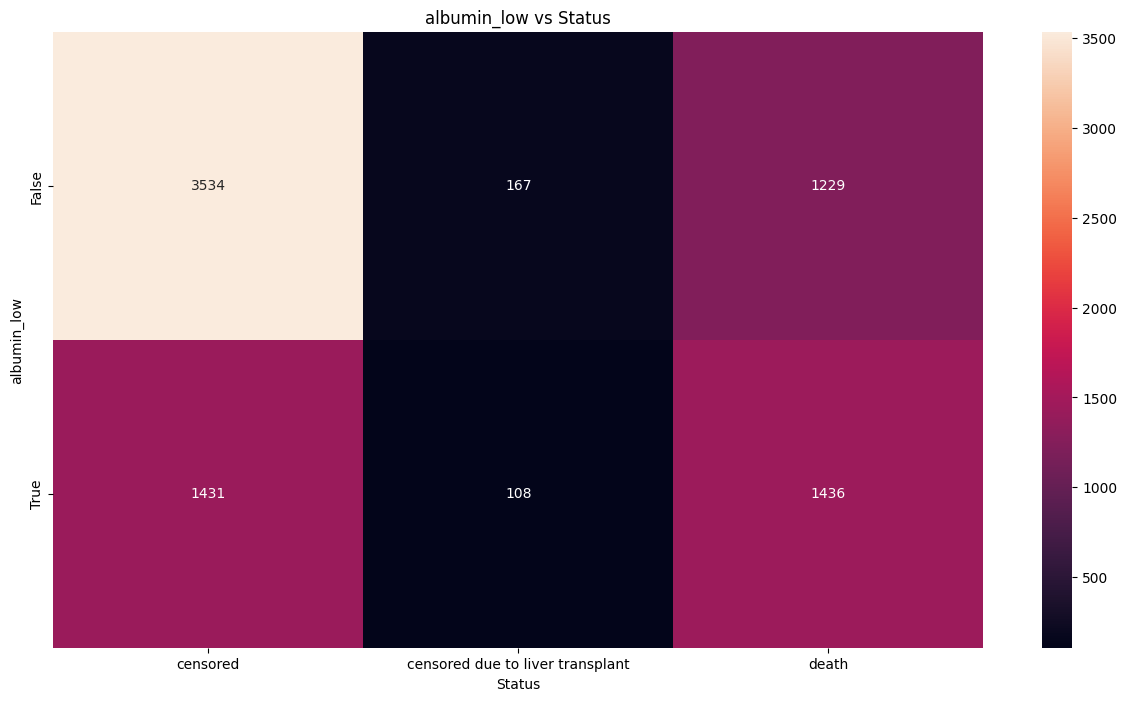

In [9]:
# NEW FEATURE: albumin_low
train_df["albumin_low"] = train_df['Albumin'] < 3.5

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.title.set_text(f"albumin_low vs Status")
sns.heatmap(pd.crosstab(train_df['albumin_low'], train_df[target_column]), annot=True, fmt='d', ax=ax)

might not be an important feature

count    7905.000000
mean       83.902846
std        75.899266
min         4.000000
25%        39.000000
50%        63.000000
75%       102.000000
max       588.000000
Name: Copper, dtype: float64


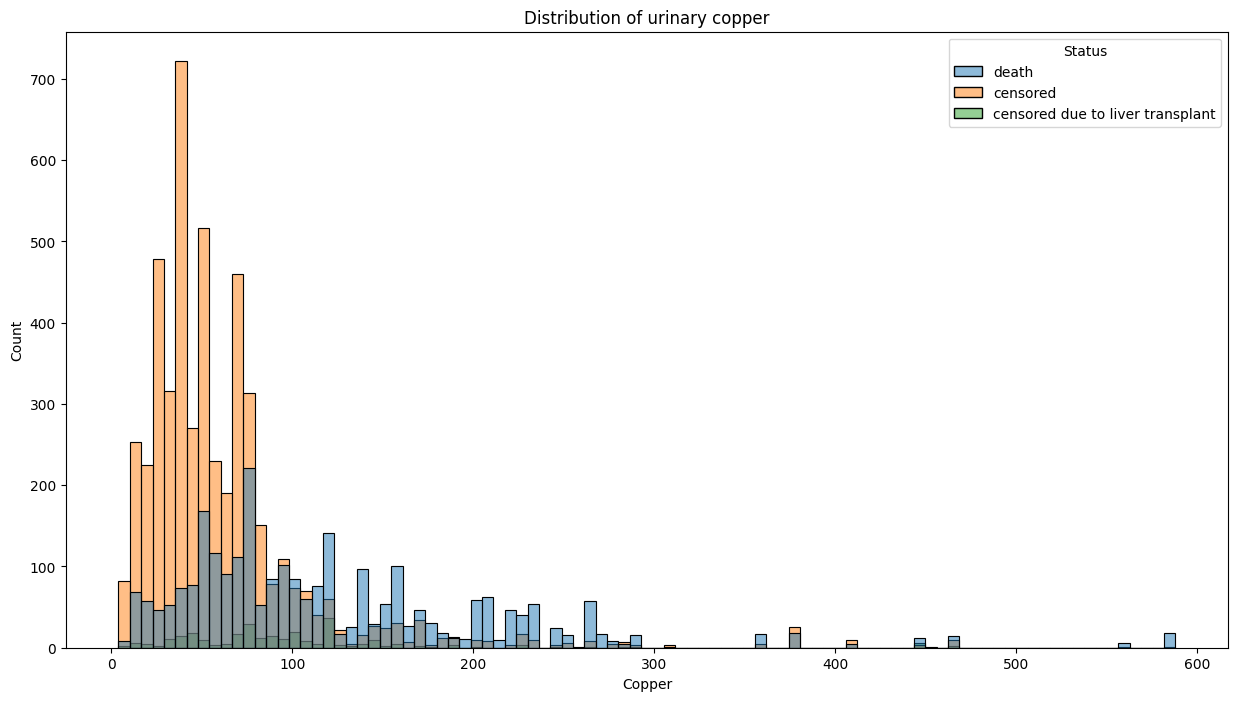

In [10]:
print(train_df['Copper'].describe())
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.title.set_text(f"Distribution of urinary copper")
sns.histplot(data=train_df, x="Copper", hue=target_column, ax=ax)
plt.show()

<Axes: title={'center': 'urinary_copper_increased vs Status'}, xlabel='Status', ylabel='urinary_copper_increased'>

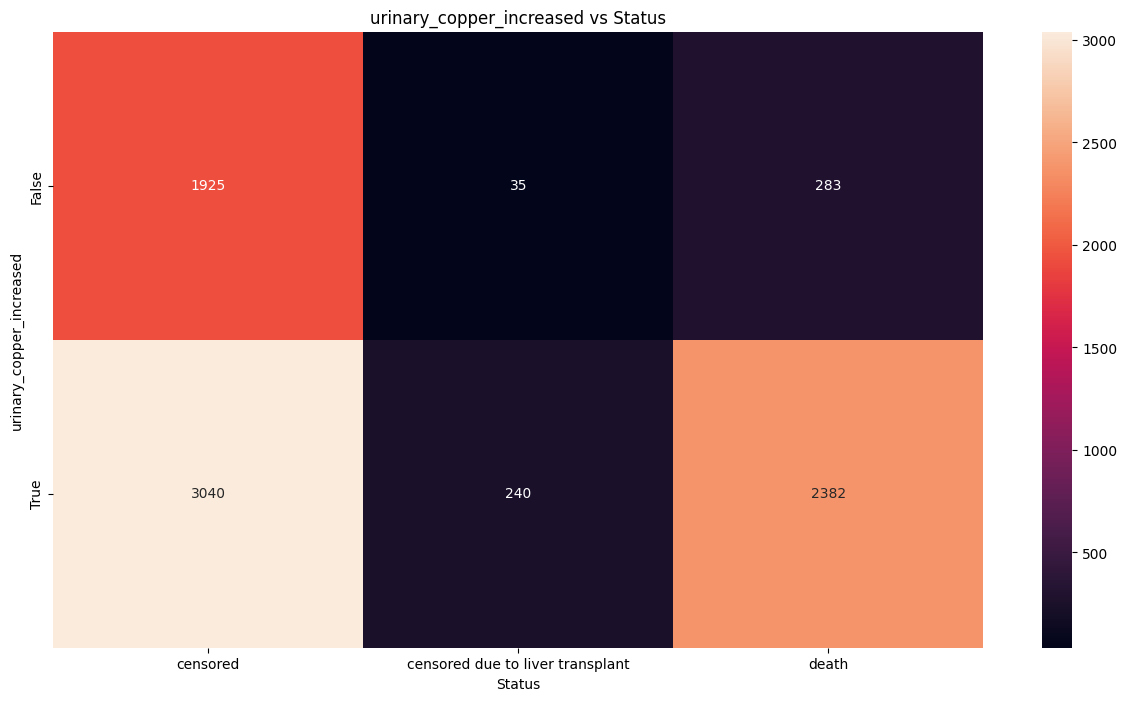

In [11]:
# NEW FEATURE: urinary_copper_increased
train_df["urinary_copper_increased"] = train_df['Copper'] > 40

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.title.set_text(f"urinary_copper_increased vs Status")
sns.heatmap(pd.crosstab(train_df['urinary_copper_increased'], train_df[target_column]), annot=True, fmt='d', ax=ax)

count     7905.000000
mean      1816.745250
std       1903.750657
min        289.000000
25%        834.000000
50%       1181.000000
75%       1857.000000
max      13862.400000
Name: Alk_Phos, dtype: float64


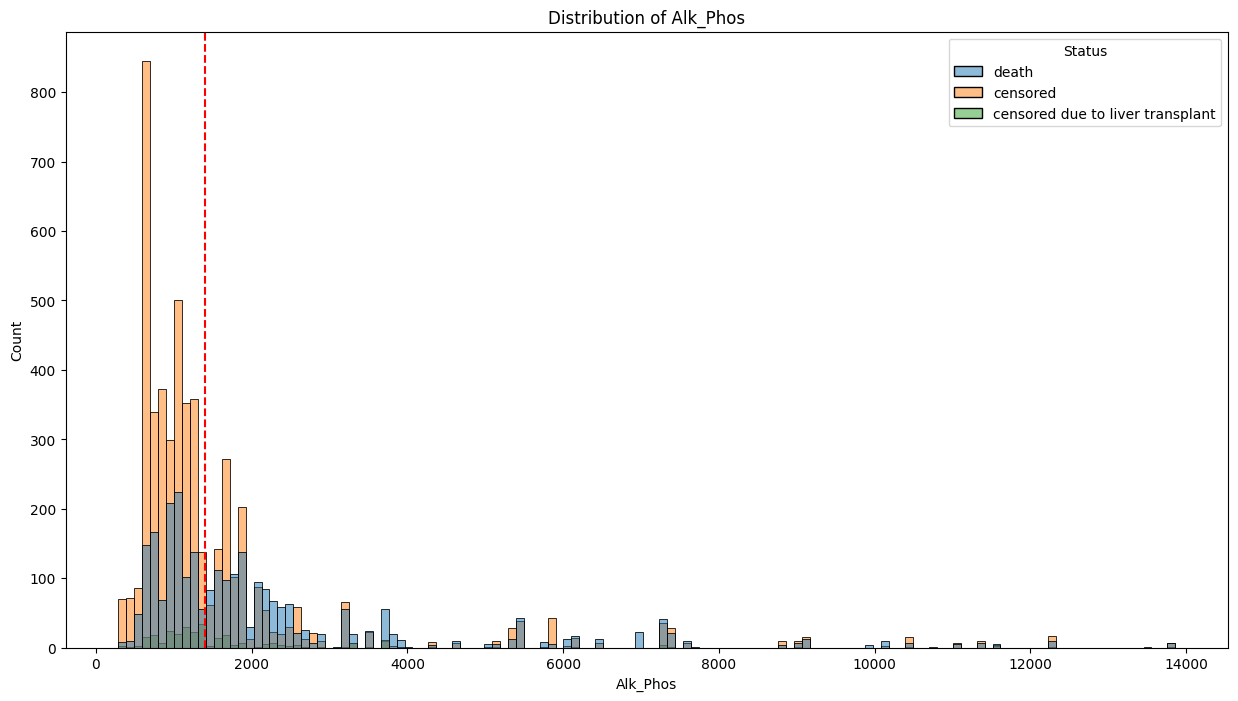

In [12]:
#Alkaline phosphatase (U/liter)
print(train_df['Alk_Phos'].describe())
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.title.set_text(f"Distribution of Alk_Phos")
sns.histplot(data=train_df, x="Alk_Phos", hue=target_column, ax=ax)

# draw vertical line at 1400
plt.axvline(x=1400, color='red', linestyle='--')
plt.show()

<Axes: title={'center': 'Alk_Phos_increased vs Status'}, xlabel='Status', ylabel='Alk_Phos_increased'>

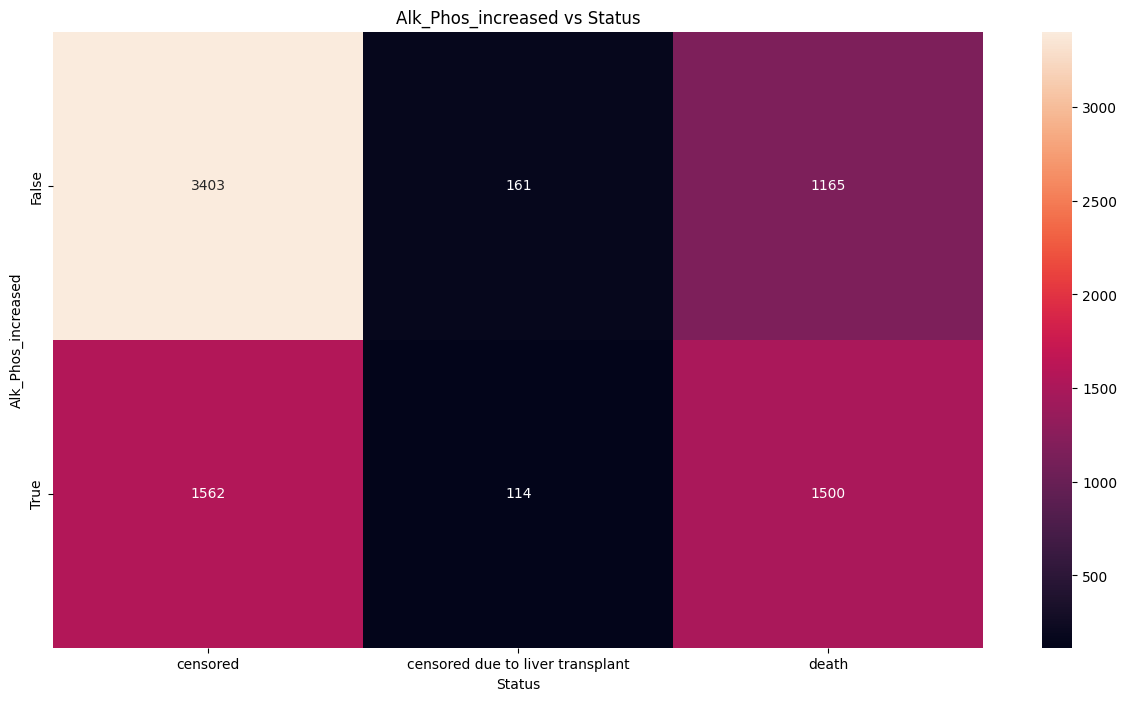

In [13]:
# NEW FEATURE: Alk_Phos_increased
train_df["Alk_Phos_increased"] = train_df['Alk_Phos'] > 1400

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.title.set_text(f"Alk_Phos_increased vs Status")
sns.heatmap(pd.crosstab(train_df['Alk_Phos_increased'], train_df[target_column]), annot=True, fmt='d', ax=ax)

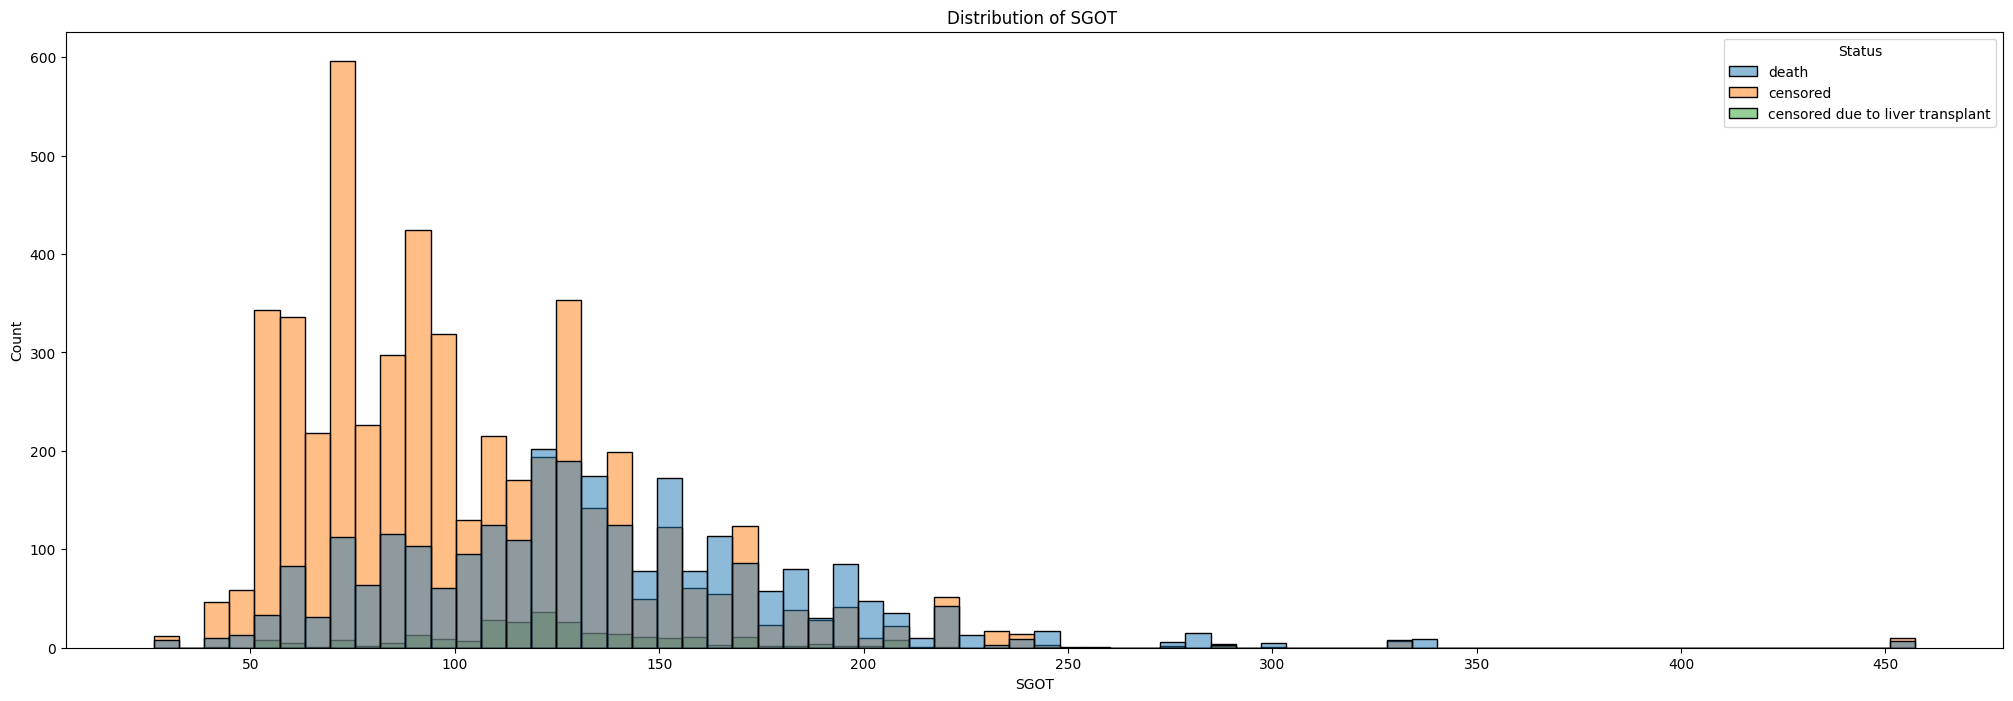

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(25, 8))
ax.title.set_text(f"Distribution of SGOT ")
sns.histplot(data=train_df, x="SGOT", hue=target_column, ax=ax)
# show x-axis ticks for every 50 units
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(50))
plt.show()

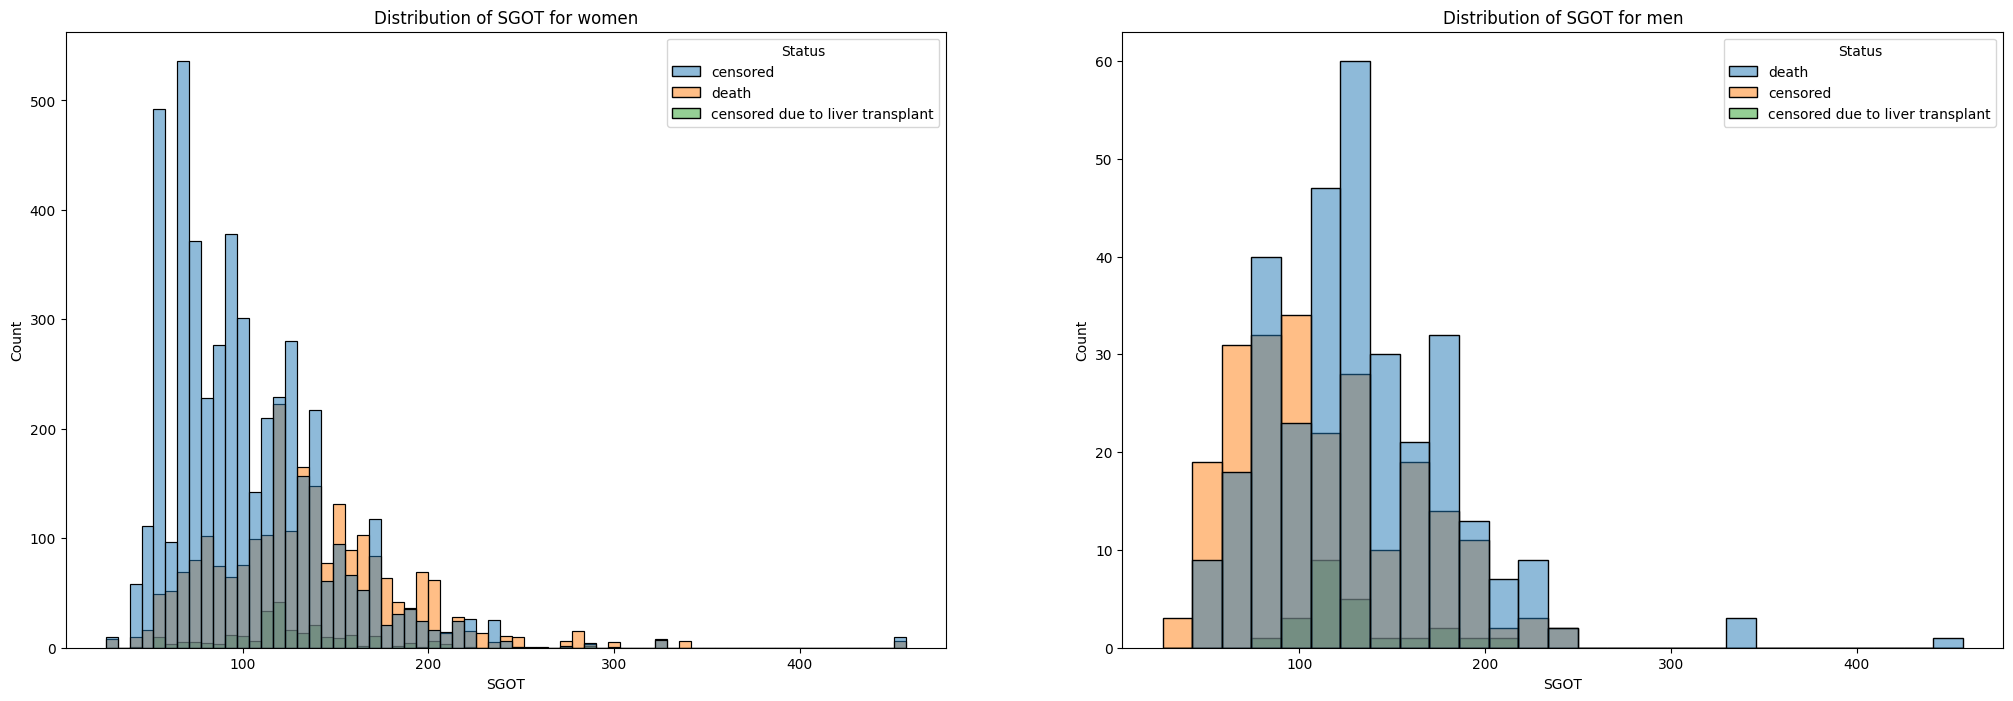

In [16]:
# SGOT
# show distribution for men and women
fig, ax = plt.subplots(1, 2, figsize=(25, 8))
ax[0].title.set_text(f"Distribution of SGOT for women")
sns.histplot(data=train_df[ train_df["Sex"] == "F" ], x="SGOT", hue=target_column, ax=ax[0])

ax[1].title.set_text("Distribution of SGOT for men")
sns.histplot(data=train_df[ train_df["Sex"] == "M" ], x="SGOT", hue=target_column, ax=ax[1])
plt.show()

In [ ]:
train_df[ train_df["Sex"] == "F" ]['SGOT'].describe(percentiles=[0.25, 0.3, 0.4, 0.5, 0.75,])

In [ ]:
train_df[ train_df["Sex"] == "M" ]['SGOT'].describe(percentiles=[0.25, 0.3, 0.4, 0.5, 0.75,])

In [ ]:
len(train_df)

In [ ]:
# calculate observed likelihood of each status based on Sex and SGOT
train_df['SGOT_increased'] = train_df["SGOT"] > 80 

# Step 2: Group data by 'Sex' and 'Status' and count occurrences
grouped_count = train_df.groupby(['Sex', "SGOT_increased", 'Status']).size()

# Step 3: Calculate total counts for each 'Sex'
sex_counts = train_df['Sex'].value_counts()

# Step 4: Calculate probabilities
probabilities = grouped_count / sex_counts

# round to 3 decimal places and add "%" at the end
probabilities = probabilities * 100
probabilities = probabilities.round(3)
probabilities = probabilities.astype(str) + '%'

# Display the probabilities
print(probabilities)

In [ ]:
# NEW FEATURE: SGOT_increased

train_df['SGOT_increased'] = train_df["SGOT"] > 80 

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.title.set_text(f"SGOT_increased vs Status")
sns.heatmap(pd.crosstab(train_df['SGOT_increased'], train_df[target_column]), annot=True, fmt='d', ax=ax)

In [ ]:
# triglycerides
print(train_df['Tryglicerides'].describe())
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.title.set_text(f"Distribution of Tryglicerides")
sns.histplot(data=train_df, x="Tryglicerides", hue=target_column, ax=ax)
plt.show()

In [ ]:
# NEW FEATURE: Tryglicerides_normal
train_df["Tryglicerides_normal"] = train_df['Tryglicerides'] < 150 

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.title.set_text(f"Tryglicerides_normal vs Status")
sns.heatmap(pd.crosstab(train_df['Tryglicerides_normal'], train_df[target_column]), annot=True, fmt='d', ax=ax)
plt.show()


In [ ]:
train_df["Tryglicerides_normal"] = train_df['Tryglicerides'] < 150 

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.title.set_text(f"Tryglicerides_normal vs Status")
sns.heatmap(pd.crosstab(train_df['Tryglicerides_normal'], train_df[target_column]), annot=True, fmt='d', ax=ax)
plt.show()


In [ ]:
# Platelets
print(train_df['Platelets'].describe())
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.title.set_text(f"Distribution of Platelets")
sns.histplot(data=train_df, x="Platelets", hue=target_column, ax=ax)
plt.show()

In [ ]:
# NEW FEATURE: Platelets_normal
train_df["Platelets_normal"] = (train_df['Platelets'] >= 150) & (train_df['Platelets'] <= 400)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.title.set_text(f"Platelets_normal vs Status")
sns.heatmap(pd.crosstab(train_df['Platelets_normal'], train_df[target_column]), annot=True, fmt='d', ax=ax)
plt.show()

## Resulting feature engineering

In [ ]:
def new_num_features(df):
    df['bilirubin_increased_levels'] = df['Bilirubin'] > 1.1
    df['cholesterol_increased'] = df['Cholesterol'] > 240
    df["albumin_low"] = df['Albumin'] < 3.5
    df["urinary_copper_increased"] = df['Copper'] > 40
    df["Alk_Phos_increased"] = df['Alk_Phos'] > 1400
    df['SGOT_increased'] = df["SGOT"] > 80 
    df["Tryglicerides_normal"] = df['Tryglicerides'] < 150 
    df["Platelets_normal"] = (df['Platelets'] >= 150) & (df['Platelets'] <= 400)
    return df

In [ ]:
IN_KAGGLE = False
kaggle_folder = "/kaggle/input/playground-series-s3e26"
local_folder = "./data"
train_df = pd.read_csv(kaggle_folder if IN_KAGGLE else local_folder + "/train.csv", index_col="id")
train_df[target_column] = train_df[target_column].map(target_map)

def feature_engineering(df):
    df['Drug'] = df['Drug'].map({"D-penicillamine": 1,"Placebo": 0})
    df['Sex'] = df['Sex'].map({"F": 1,"M": 0})

    df["Stage"] = df["Stage"].apply(lambda x: str(x))
    return df


train_df = feature_engineering(train_df)
train_df = new_num_features(train_df)

train_df = train_df.drop(labels=["Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets"], axis=1)
features_to_remove = ["Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets"]
numerical_features = [ n for n in numerical_features if n not in features_to_remove ]
categorical_features += ["bilirubin_increased_levels", "cholesterol_increased", "albumin_low", "urinary_copper_increased", "Alk_Phos_increased", "SGOT_increased", "Tryglicerides_normal", "Platelets_normal"]

X = train_df.drop(columns=target_column)
y = train_df[target_column]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=RANDOM_SEED, stratify=y, shuffle=True)

le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

numeric_transformer = Pipeline(
    [
        #("power_transformer", PowerTransformer()),
        ("scaler", StandardScaler()),
        
    ]
)

categorical_transformer = Pipeline(
    [
        ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


for model_name, model in models.items():
    model_name += " with new features"
    print(f"Training {model_name}")
    clf = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("classifier", model),
        ]
    )

    cc_cv = CalibratedClassifierCV(clf, cv=skf)

    cc_cv.fit(X_train, y_train)
    y_pred_proba = cc_cv.predict_proba(X_val)
    y_pred = cc_cv.predict(X_val)
    
    cr = classification_report(y_val, y_pred, output_dict=True)

    recall_class_0 = confusion_matrix(y_val, y_pred, normalize="true")[0, 0]
    recall_class_1 = confusion_matrix(y_val, y_pred, normalize="true")[1, 1]
    recall_class_2 = confusion_matrix(y_val, y_pred, normalize="true")[2, 2]
    data.append({
        "model": model_name, 
        "log_loss_score": log_loss(y_val, y_pred_proba),
        "avg_precision": cr["macro avg"]["precision"],
        "f1_score": cr["macro avg"]["f1-score"],
        "recall_class_0": recall_class_0,
        "recall_class_1": recall_class_1,
        "recall_class_2": recall_class_2,
    })    

In [ ]:
pd.DataFrame(data).drop_duplicates().sort_values(by=["log_loss_score", "recall_class_1"], ascending=[True, False])

In [ ]:
clf = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", models["stacking classifier 1"]),
    ]
)

In [ ]:
# final submission

IN_KAGGLE = False
kaggle_folder = "/kaggle/input/playground-series-s3e26"
local_folder = "./data"
train_df = pd.read_csv(kaggle_folder if IN_KAGGLE else local_folder + "/train.csv", index_col="id")
test_df = pd.read_csv(kaggle_folder if IN_KAGGLE else local_folder  + "/test.csv", index_col="id")
target_column = "Status"

categorical_features = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]
numerical_features = ["N_Days", "Age", "Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]
run_feature_engineering = True

train_df = feature_engineering(train_df)
train_df = new_num_features(train_df)

test_df = feature_engineering(test_df)
test_df = new_num_features(test_df)


train_df = train_df.drop(labels=["Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets"], axis=1)
test_df = test_df.drop(labels=["Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets"], axis=1)

features_to_remove = ["Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets"]
numerical_features = [ n for n in numerical_features if n not in features_to_remove ]
categorical_features += ["bilirubin_increased_levels", "cholesterol_increased", "albumin_low", "urinary_copper_increased", "Alk_Phos_increased", "SGOT_increased", "Tryglicerides_normal", "Platelets_normal"]

X_train = train_df.drop(columns=target_column)
X_test = test_df

le = LabelEncoder()

y_train = train_df[target_column]
y_train = le.fit_transform(y_train)


clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)

submission_df = pd.DataFrame(y_pred, index=X_test.index, columns=[f"Status_{target}" for target in le.classes_])
submission_df.to_csv("./submission.csv")
submission_df

## Summary & Conclusion